In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as la

# covariances
Q = np.array([[2, 2], [2, 2]])
R = np.array([[3]])

# state dynamics
A = np.array([[1, -1], [0, 0.8]])
H = np.array([[1, 1]])
H1 = np.array([1, 1])

P0 = np.array([[2, 1], [1, 4]])
xhat0 = np.array([1, 2])

# controlled feedback
B = np.array([[1], [0]])
F = np.array([0.9, -0.9]).reshape(1, 2)
N = 100


In [ ]:
################## Q2 #####################
# Compute the Kalman variances
# Outputs are the sequences Pbar_k, P_k and K_k up to N
def kalman_var_2d(A, H, P0, Q, R, N):
    I = np.identity(2)
    P = [P0]
    Pbar =[0] # creates a dummny value for bar P_0
    K = [0] # creates a dummny value for K_0
    for n in range(1, N + 1):
        Pbef = P[-1]
        Pbar_n = ((A @ Pbef) @ A.T) + Q
        RR = ((H @ Pbar_n) @ H.T) + R
        K_n = (Pbar_n @ H.T) @ la.inv(RR)
        Pnext = (I - (K_n @ H)) @ Pbar_n

        P.append(Pnext)
        Pbar.append(Pbar_n)
        K.append(K_n)
    return P, Pbar, K

P, Pbar, K = kalman_var_2d(A, H, P0, Q, R, N)
# Print the final Covariance Matrices and Gaines 
print("\nThe final Error Covariance is:")
print(P[-1])
print("\nThe final Pre-observation Error Covariance is:")
print(Pbar[-1])
print("\nThe final Gains Matrix is:")
print(K[-1])


The final Error Covariance is:
[[ 8.28537641 -5.52380475]
 [-5.52380475  5.34765476]]

The final Pre-observation Error Covariance is:
[[26.68064068 -6.69716761]
 [-6.69716761  5.42249905]]

The final Gains Matrix is:
[[ 0.92052389]
 [-0.05871666]]


In [ ]:
################## Q3 #####################
def kalman_simulate(A, H, P0, xhat0, Q, R, N):
    # simulate states and observations from state dynamics
    # outputs are the state and the observation
    dim,_ = A.shape # dim = 2
    x_mu = np.zeros(dim) 
    o_mu = np.zeros(1)
    x0 = np.random.multivariate_normal(x_mu, P0).T + xhat0
    x = [x0] # initial state
    obs = []  # dummy observation
    for t in range (1, N + 1):
        xprev = x[-1]
        omega_t = np.random.multivariate_normal(x_mu, Q).T
        xt = A @ xprev + omega_t

        nu_t = np.random.normal(0, 3, 1).T
        zt = H @ xt + nu_t

        x.append(xt)
        obs.append(zt) 
    return x, obs

In [ ]:
def kalman_plot(A, H, P0, xhat0, Q, R, N):
    # ploting the component 'comp'
    dim,_ = A.shape
    ell = np.array([H]).shape
    x, z = kalman_simulate(A, H1, P0, xhat0, Q, R, N)
    xhat = kalman_estimate(A, H, P0, xhat0, Q, R, z, N) 

################## Q3 #####################
    for comp in range(dim):
        x_comp = [x[t][comp] for t in range(N)]
        plt.figure(figsize=(7, 4))
        plt.plot(np.arange(N), x_comp, color ="magenta")
        plt.xlabel("Time"); 
        plt.title("State dynamics (x) in the %d-th component"%(comp + 1))
        plt.show()

    #print(z)
    plt.figure(figsize=(7, 4))
    plt.plot(np.arange(N), z, color ="orange")
    plt.xlabel("Time"); 
    plt.title("Observations (z) over time")
    plt.show()
        
################## Q5 #####################
    xhat = kalman_estimate(A, H, P0, xhat0, Q, R, z, N)
    for comp in range(dim):
        x_comp = [x[t][comp] for t in range(N)]
        x_hat_comp = [xhat[t][comp] for t in range(N)]
        plt.figure(figsize=(7, 4))
        plt.plot(np.arange(N), x_comp, color ="magenta", label = 'state x')
        plt.plot(np.arange(N), x_hat_comp, color ="cyan", label = "state estimate xhat")
        plt.legend()
        plt.xlabel("Time"); 
        plt.title("State dynamics (x) vs. estimates (xhat) in the %d-th component"%(comp + 1))
        plt.show()

In [ ]:
################## Q5 #####################
def kalman_estimate(A, H, P0, xhat0, Q, R, z, N):
    # Given the observations we calculate the state estimate
    P, Pbar, K = kalman_var_2d(A, H, P0, Q, R, N)
    xhat = [xhat0]
    for t in range(1, len(z)):
        iota_t = z[t] - H @ (A @ xhat[-1])
        xhat_t = A @ xhat[-1] + K[t] @ iota_t
        xhat.append(xhat_t)
    return xhat

In [ ]:
def kalman_plot_control(A, H, B, F, P0, xhat0, Q, R, N):
    # plotting the component 'comp'
    dim,_ = A.shape
    ell = np.array([H]).shape
    x, z, xhat = kalman_simulate_control(A, H, B, F, P0, xhat0, Q, R, N)

################## Q8 #####################
    for comp in range(dim):
        x_comp = [x[t][comp] for t in range(N)]
        x_hat_comp = [xhat[t][comp] for t in range(N)]
        plt.figure(figsize=(7, 4))
        plt.plot(np.arange(N), x_comp, color ="magenta", label = 'state x')
        plt.plot(np.arange(N), x_hat_comp, color ="cyan", label = "state estimate xhat")
        plt.legend()
        plt.xlabel("Time"); 
        plt.title("Controlled state dynamics (x) vs. estimates (xhat) in the %d-th component"%(comp + 1))
        plt.show()

In [ ]:
################## Q8 #####################
def kalman_simulate_control(A, H, B, F, P0, xhat0, Q, R, N):
    # simulates state and observations from Gaussian
    # outputs the state, estimate, and observation
    # B: the B control matrix
    # f: the matrix such that control = - F estimate

    dim,_ = A.shape # dim = 2
    x_mu = np.zeros(dim) 
    P, Pbar, K = kalman_var_2d(A, H, P0, Q, R, N)
    o_mu = np.zeros(1)
    x0 = np.random.multivariate_normal(x_mu, P0).T + xhat0
    x = [x0] # initial state
    xhat = [xhat0] # initial estimate
    obs = []  # dummy observation

    for t in range (1, N + 1):
        omega_t = np.random.multivariate_normal(x_mu, Q).T
        control = -(B @ F) @ xhat[-1]
        xt      = (A @ x[-1]) + omega_t + control

        nu_t    = np.random.normal(0, 3, 1).T
        zt      = H @ xt + nu_t

        xhat_pre = A @ xhat[-1] + control
        iota_t   = zt - (H @ xhat_pre)
        xhat_t   = xhat_pre + (K[t] @ iota_t)
        x.append(xt)
        obs.append(zt)
        xhat.append(xhat_t)
    # print(x[-1], xhat[-1], obs[-1])
    return x, obs, xhat

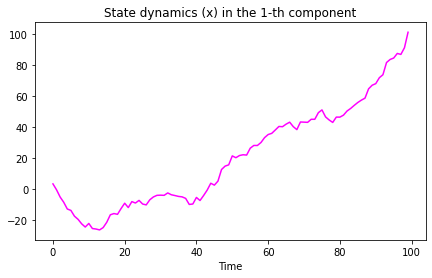

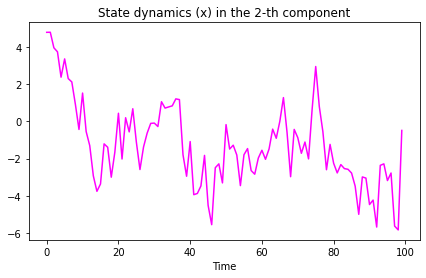

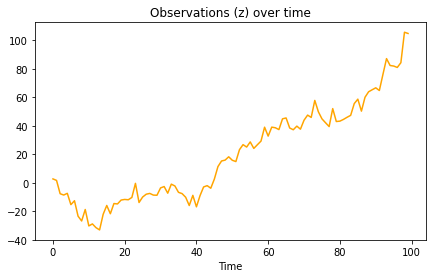

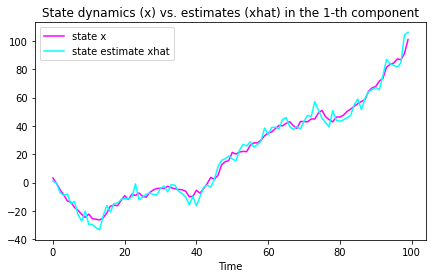

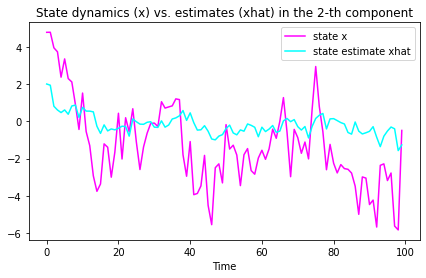

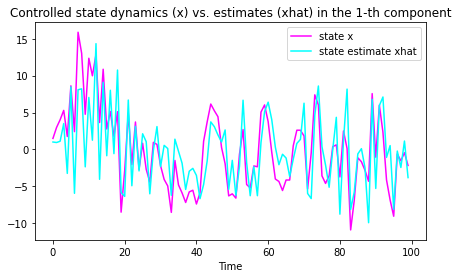

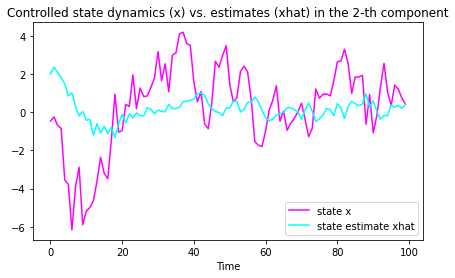

In [ ]:
kalman_plot(A, H, P0, xhat0, Q, R, N)
kalman_plot_control(A, H, B, F, P0, xhat0, Q, R, N)